In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. Emission Mixtures/P1011.3. Analyses/P1011.3.1. Data Processing/Output')
cur_date = "090223"

library(readxl)
library(openxlsx)
library(tidyverse)
library(reshape2)
library(data.table)
library(factoextra)
library(ggrepel)
library(pheatmap)
#library(imputeLCMD)
#library(vsn)

# reading in file
cytokine_df = data.frame(read_excel("Input/Cytokine_Data_050423.xlsx", sheet = 2)) %>%
    rename(Dose = Condensate_Conc) %>%
    # only interested in doses 1, 25, and control
    filter(Dose %in% c(1,25,NA))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from

In [2]:
head(cytokine_df)

,Subject_No,Subject_ID,Condensate,Burn_Condition,Dose,Cytokine,Cytokine_Conc,Cytokine_Conc_pslog2
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,1,F_1,C,F,1,Eotaxin3,21.750958,4.507855
2,1,F_1,C,F,25,Eotaxin3,11.624224,3.658123
3,1,F_1,C,S,1,Eotaxin3,22.798534,4.572801
4,1,F_1,C,S,25,Eotaxin3,10.342567,3.503675
5,1,F_1,C,F,1,GMCSF,1.910502,1.541268
6,1,F_1,C,F,25,GMCSF,8.931102,3.311954


In [3]:
# checking for duplicates
Dups = duplicated(cytokine_df)
summary(Dups)

   Mode   FALSE 
logical     918 

In [4]:
# # doing some initial data formatting
# wider_cytokine_df = cytokine_df %>%
#     rename(Dose = Condensate_Conc) %>%
#     # only interested in doses 1 and 25
#     filter(Dose %in% c(1,25))
#     # creating sample ids
#     unite("SampleID", c(colnames(cytokine_df)[c(1,3:5)]), sep = "_") %>%
#     select(-c("Cytokine_Conc_pslog2", "Subject_ID")) %>%
#     pivot_wider(names_from = "SampleID", values_from = "Cytokine_Conc") %>%
#     column_to_rownames(var = "Cytokine")

No duplicates. Now creating dataframes that are formatted for proceeding code, as well as DESeq2 functions.

In [5]:
# first creating a `coldata` object that contains all the metadata for each sample
coldata = unique(cytokine_df[,1:5]) %>%
    filter(Dose %in% c(1,NA)) %>%
    select(-Dose) %>%
    # creating sample ids
    unite("SampleID", c(colnames(cytokine_df))[c(1,3,4)], sep = "_", remove = FALSE)

head(coldata)

,SampleID,Subject_No,Subject_ID,Condensate,Burn_Condition
,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1_C_F,1,F_1,C,F
2,1_C_S,1,F_1,C,S
3,2_C_F,2,M_2,C,F
4,2_C_S,2,M_2,C,S
5,3_C_F,3,M_3,C,F
6,3_C_S,3,M_3,C,S


In [6]:
# making a `countdata` obj that contains cytokines as rows and sample names as cols
countdata = cytokine_df %>%
    filter(Dose %in% c(1,NA)) %>%
    select(-Dose) %>%
# creating sample ids
    unite("SampleID", c(colnames(cytokine_df)[c(1,3:4)]), sep = "_") %>%
    select(-c("Cytokine_Conc_pslog2", "Subject_ID")) %>%
    pivot_wider(names_from = "SampleID", values_from = "Cytokine_Conc") %>%
    column_to_rownames(var = "Cytokine")

head(countdata)

,1_C_F,1_C_S,2_C_F,2_C_S,3_C_F,3_C_S,4_C_F,4_C_S,5_C_F,5_C_S,⋯,5_P_F,5_P_S,6_P_F,6_P_S,1_PBS_PBS,2_PBS_PBS,3_PBS_PBS,4_PBS_PBS,5_PBS_PBS,6_PBS_PBS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin3,21.7509578,22.79853427,9.4828925,12.6741020,18.4398691,16.4146637,4.4829115,9.5209271,7.573477,3.6296576,⋯,6.7991874,2.5391094,3.2070731,7.193271,6.5164096,4.09746381,8.7016042,11.6088683,5.82224401,8.3443377
GMCSF,1.9105023,1.42736197,1.6934569,1.3916790,8.2429786,6.0218778,8.3059936,10.5290902,2.452392,2.1404754,⋯,0.9946222,2.0659819,3.8135098,7.172952,1.2155607,4.82560648,2.7232247,0.4618191,0.56449034,0.7176056
IL10,0.3885503,0.05697711,0.2349819,0.3546597,0.3163962,0.3140775,1.3321109,1.9886760,1.600229,1.8291945,⋯,0.9236629,1.2991277,2.9059010,3.019063,0.6951089,0.45756637,0.3243074,0.7354434,2.42846040,1.8449935
IL13,14.5879538,2.50176460,12.4418665,8.7577660,25.9946091,27.6393773,35.5467587,27.2435905,28.484812,51.3058197,⋯,30.4906672,36.9444166,36.2466305,49.057905,32.3446737,51.55220801,22.4430018,40.1092582,45.00685705,48.1459764
IL15,0.3237601,0.30452873,0.3412690,0.4024510,1.8320968,1.6673361,0.4390184,0.4389947,2.283583,2.0461378,⋯,0.9462201,2.0408351,0.9859481,1.998325,0.5040196,0.41471943,0.1600225,0.3335528,0.38695213,0.4394744
IL1a,1.1257898,0.37538110,1.7955959,0.4593748,0.9815676,1.6244131,0.5076990,1.8242721,2.685869,0.7289766,⋯,0.2647102,0.8654108,2.4299206,1.527494,0.3943214,0.04431924,1.7533717,0.2403669,0.06152603,0.6930547


In [7]:
# checking for duplicates
summary(duplicated(coldata))
summary(duplicated(countdata))

# getting dimensions
dim(coldata)
dim(countdata)

   Mode   FALSE 
logical      30 

   Mode   FALSE 
logical      17 

[1] 30  5

[1] 17 30

In [8]:
# Set the rownames of coldata and column names of countdata to be in the same order 
countdata <- setcolorder(countdata, as.character(coldata$SampleID))

# replacing the sample ids in the countdata file with the ids
#colnames(countdata) <- coldata$ID

head(countdata)

,1_C_F,1_C_S,2_C_F,2_C_S,3_C_F,3_C_S,4_C_F,4_C_S,5_C_F,5_C_S,⋯,5_P_F,5_P_S,6_P_F,6_P_S,1_PBS_PBS,2_PBS_PBS,3_PBS_PBS,4_PBS_PBS,5_PBS_PBS,6_PBS_PBS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin3,21.7509578,22.79853427,9.4828925,12.6741020,18.4398691,16.4146637,4.4829115,9.5209271,7.573477,3.6296576,⋯,6.7991874,2.5391094,3.2070731,7.193271,6.5164096,4.09746381,8.7016042,11.6088683,5.82224401,8.3443377
GMCSF,1.9105023,1.42736197,1.6934569,1.3916790,8.2429786,6.0218778,8.3059936,10.5290902,2.452392,2.1404754,⋯,0.9946222,2.0659819,3.8135098,7.172952,1.2155607,4.82560648,2.7232247,0.4618191,0.56449034,0.7176056
IL10,0.3885503,0.05697711,0.2349819,0.3546597,0.3163962,0.3140775,1.3321109,1.9886760,1.600229,1.8291945,⋯,0.9236629,1.2991277,2.9059010,3.019063,0.6951089,0.45756637,0.3243074,0.7354434,2.42846040,1.8449935
IL13,14.5879538,2.50176460,12.4418665,8.7577660,25.9946091,27.6393773,35.5467587,27.2435905,28.484812,51.3058197,⋯,30.4906672,36.9444166,36.2466305,49.057905,32.3446737,51.55220801,22.4430018,40.1092582,45.00685705,48.1459764
IL15,0.3237601,0.30452873,0.3412690,0.4024510,1.8320968,1.6673361,0.4390184,0.4389947,2.283583,2.0461378,⋯,0.9462201,2.0408351,0.9859481,1.998325,0.5040196,0.41471943,0.1600225,0.3335528,0.38695213,0.4394744
IL1a,1.1257898,0.37538110,1.7955959,0.4593748,0.9815676,1.6244131,0.5076990,1.8242721,2.685869,0.7289766,⋯,0.2647102,0.8654108,2.4299206,1.527494,0.3943214,0.04431924,1.7533717,0.2403669,0.06152603,0.6930547


In [9]:
# Double checking that the same variables appear between the two dataframes
setequal(as.character(coldata$SampleID), colnames(countdata))

# Additionally checking that not only the sets of variables are the same, but that they are in the same order
identical(as.character(coldata$SampleID), colnames(countdata))

[1] TRUE

[1] TRUE

# Transcriptomics QA/QC 
Performed on raw count data to identify potential outlier samples. Starting by filtering lowly expressed cytokines.

In [10]:
# First count the total number of samples and save it as a value in the global environment
nsamp <- ncol(countdata)

# Then, calculate the median expression level across all genes and all samples and save it as a value
total_median <- median(as.matrix(countdata))

# We need to temporarily add back in the cytokine column to the countdata 
# so we can filter for genes that pass the background filter
countdata <- countdata %>% 
    rownames_to_column("Cytokine")

In [11]:
# filtering for cytokines that have an expression greater than the total median in at least 20% of the samples
cytokines_above_background <- countdata %>% 
    pivot_longer(cols =! Cytokine, names_to = "sampleID", values_to = "expression") %>% 
    # indicates whether the expression of a cytokine for the corresponding exposure condition is above (1) or not 
    # above (0) the median of all count data
    mutate(above_median = ifelse(expression > total_median,1,0)) %>% 
    group_by(Cytokine) %>% 
    # For each cytokine, count the number of exposure conditions where the expression was greater than the median 
    # of all count data
    summarize(total_above_median = sum(above_median)) %>% 
    # Filter for cytokines that have expression above the median in at least 20% of the samples
    filter(total_above_median >= 0.2*nsamp) %>% 
    select(Cytokine) 

# Then filter the original 'countdata' dataframe for only the cytokines above background. 
countdata <- left_join(cytokines_above_background, countdata, by = "Cytokine")

dim(countdata)

[1] 11 31

This dataframe went from having 17 cytokines to 11 cytokines. Now filtering samples with no expression. 

In [12]:
countdata_T <- countdata %>% 
  pivot_longer(cols =! Cytokine, names_to = "sampleID",values_to = "expression") %>% 
  pivot_wider(names_from = Cytokine, values_from = expression)

# Then add in a column to the transposed countdata dataframe that sums expression across all cytokines for each 
# exposure condition
countdata_T$rowsum <- rowSums(countdata_T[2:ncol(countdata_T)])

# Remove samples that have no expression
countdata_T <- countdata_T %>% 
    filter(rowsum != 0)

# Take the count data filtered for correct samples, remove the 'rowsums' column
countdata_T <- countdata_T %>% 
    select(!rowsum) 

# Then, transpose it back to the correct format for analysis
countdata <- countdata_T %>%
  pivot_longer(cols =! sampleID, names_to = "Cytokine", values_to = "expression") %>% 
  pivot_wider(names_from = sampleID, values_from = "expression") %>%
    column_to_rownames(var = "Cytokine")

dim(countdata)

[1] 11 30

No samples were removed. Now finding and removing sample outliers using PCA and hierarchical clustering.

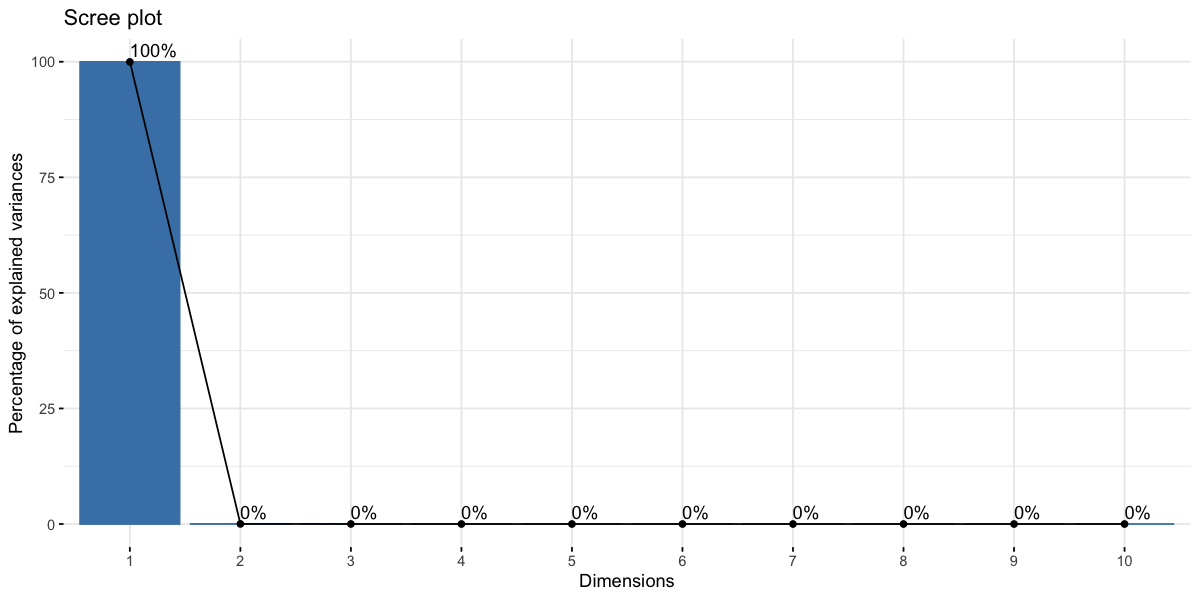

In [13]:
# PCA helps in identifying outlying samples for quality control and gives a feeling for the principal causes of 
# variation in a dataset

# Calculate principal components using transposed count data
pca <- prcomp(t(countdata))

options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(pca, addlabels = TRUE)

In [14]:
# Make dataframe for PCA plot generation using first two components and the sample name
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], SampleID = colnames(countdata))

# Calculating percent of the variation that is captured by each principal component
pca_percent <- round(100*pca$sdev^2/sum(pca$sdev^2), 1)

# Organize dataframe so we can color our points by burn condition
pca_df <- pca_df %>% 
    separate(SampleID, into = c("SubjectNo", "Condensate", "Burn_Condition"), sep = "_", remove = FALSE)

head(pca_df)

,PC1,PC2,SampleID,SubjectNo,Condensate,Burn_Condition
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1_C_F,9003.048,122.83633,1_C_F,1,C,F
1_C_S,11768.351,-348.64904,1_C_S,1,C,S
2_C_F,6763.129,231.15889,2_C_F,2,C,F
2_C_S,6736.639,221.75375,2_C_S,2,C,S
3_C_F,5474.315,-94.16694,3_C_F,3,C,F
3_C_S,7203.835,-172.30209,3_C_S,3,C,S


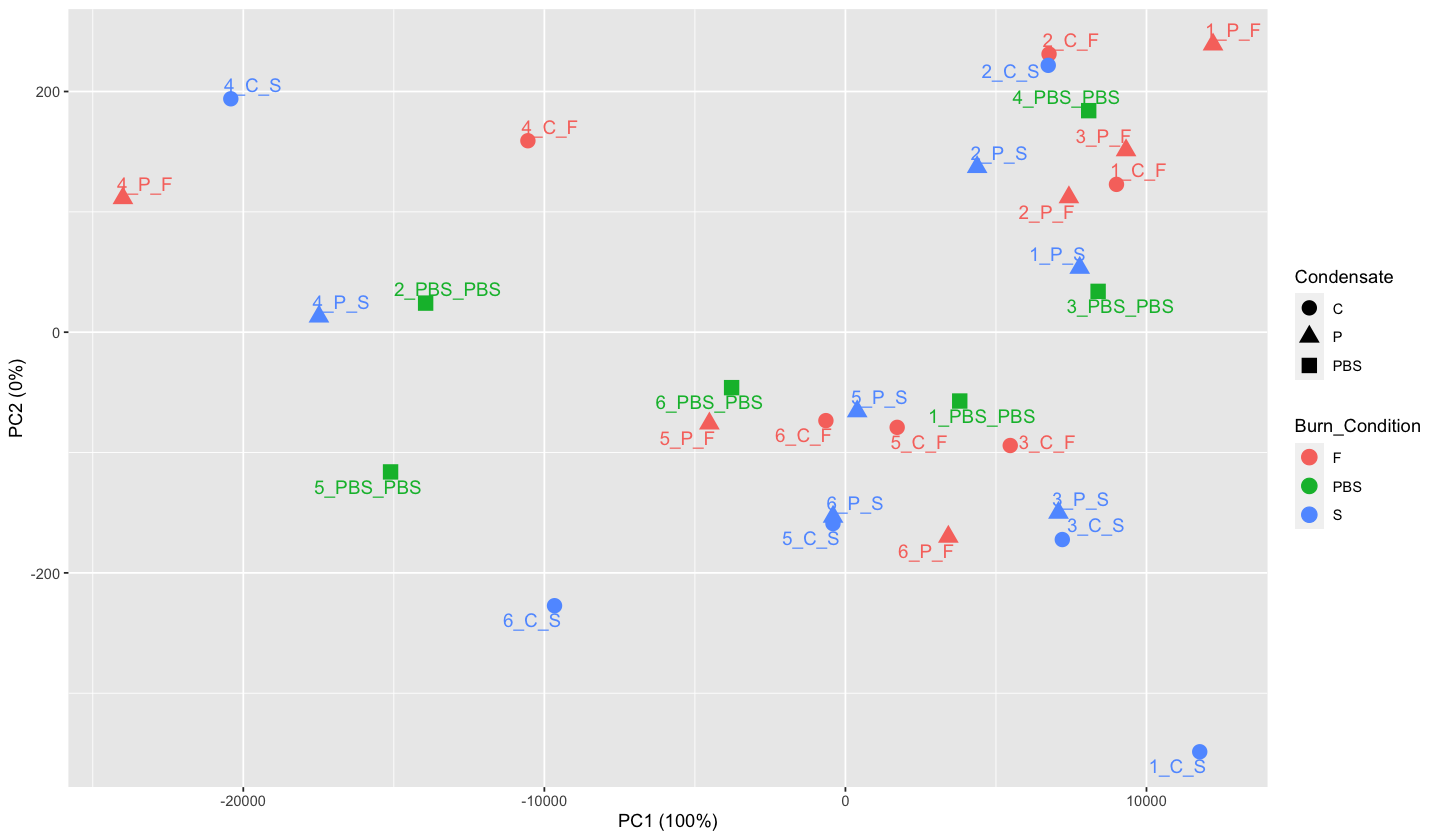

In [15]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

# color by burn condition and condensate
ggplot(pca_df, aes(PC1, PC2, color = Burn_Condition, shape = Condensate)) +
  geom_point(size = 4) +
  geom_text_repel(aes(label = SampleID), size = 4) +
  labs(x = paste0("PC1 (",pca_percent[1],"%)"), y = paste0("PC2 (",pca_percent[2],"%)"))

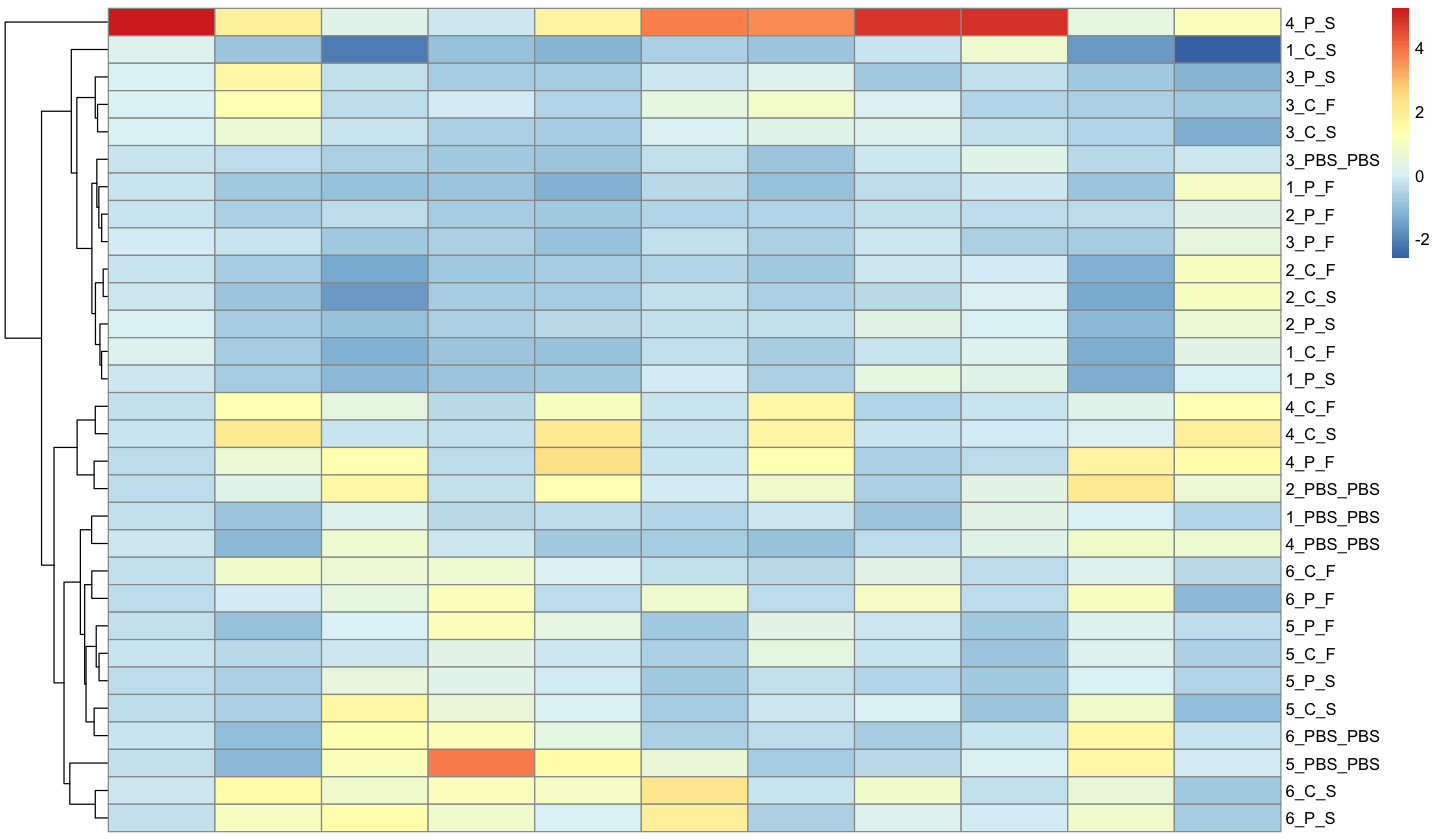

In [16]:
countdata_for_clustering <- t(countdata)

pheatmap(scale(countdata_for_clustering), 
         cluster_rows = TRUE, cluster_cols = FALSE, fontsize_col = 7, treeheight_row = 60, show_colnames = FALSE)

No sample outliers from PCA or hierarchical clustering. However, 4_P_S does look like an outlier in hierarchical clustering. Next we'll control for sources of sample heterogeneity.

In [17]:
# # First we store the treatment IDs and exposure conditions as a separate vector
# ID <- coldata$SampleID

# # And differentiate our treatments and control conditions, first by grabbing groups associated with each sample
# groups <- as.factor(coldata$Group)

# groups